In [98]:
import pandas as pd
import numpy as np
import importlib
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks
from pandas.core.interchange.dataframe_protocol import DataFrame
from pygments.lexer import bygroups

import volpy_func_lib as vp
import load_clean_lib
import table_lib

from datetime import datetime
from volpy_func_lib import load_forward_price

In [99]:
# 3 cleaning bud:

# mid price for option > x  (x=~0.1)
# volumen > x
# bid ask spread / mid price < x

In [100]:
importlib.reload(vp)
importlib.reload(load_clean_lib)
importlib.reload(table_lib)

<module 'table_lib' from 'D:\\Professionelt\\Code\\volpy\\table_lib.py'>

# Lav Data

## Load, Clean and Prepare data

In [101]:
# Load data
profile = "Mads"
data_folder = "US ZOO"   # "i4s4"  ,   "US ZOO"
tickers = ['SPX', 'OEX', "DJX", "DNX", "GE", "AMZN", "TSLA"] #  None
# tickers = ["SPX", "OEX", "AMZN"]
od, FW, ZCY_curves, returns_and_prices = load_clean_lib.load_od_FW_ZCY(profile, data_folder, tickers = tickers)
first_day = od["date"].min()
last_day = od["date"].max()

# first_day = pd.to_datetime("1996-01-04")
# last_day = pd.to_datetime("2003-02-28")

# Clean data
od = load_clean_lib.clean_od(od, first_day = first_day, last_day = last_day)

## Realized vol calculation

In [102]:
real_vol = vp.calc_realized_var(returns_and_prices, first_day, last_day)

### Add FW to options

In [103]:
od = vp.add_FW_to_od(od, FW)

### remove if ITM

In [104]:
od = od.loc[
    ((od["F"] < od["K"]) & (od["cp_flag"] == "C")) | ((od["F"] > od["K"]) & (od["cp_flag"] == "P"))
]

In [105]:
# od = od[od["volume"] > 0]

### Add r to options

In [106]:
od = vp.add_r_to_od_parallel(od, ZCY_curves)

## Add low/high and create summary (Filters dataset for criteria such as min 3 strikes ... min 8 days...)

In [107]:
od, summary_dly_df = vp.od_filter_and_summary_creater(od)

### only keep the lowest ("low") and the second lowest ("high") TTMs

In [108]:
od_rdy = od[(od["low"] == True) | (od["high"] == True)]

## Calculate swap rate

In [112]:
summary_dly_df = vp.fill_swap_rates(summary_dly_df, od_rdy, n_points=200)

## Save/Load CSV

In [110]:
# Save
date_str = datetime.now().strftime("%Y-%m_%d_%H-%M")
summary_dly_df.to_csv(f"data/summary_dly_df {date_str}.csv")
od_rdy.to_csv(f"data/od_rdy {date_str}.csv")

# Load
summary_dly_df = pd.read_csv(f"data/summary_dly_df {date_str}.csv")
od_rdy = pd.read_csv(f"data/od_rdy {date_str}.csv")

### her kan du evt. loade fra filen summary_df_dly fra drive (HELLE/Kandidat/results df/summary_dly_df 2025-03_11_11-44.csv). Dette er df over 58 aktiver for 1996-2023

In [ ]:
summary_dly_df = pd.read_csv(f"data/summary_dly_df 2025-03_11_11-44.csv")

## Keep only active days, and take average for table (just overview)

In [111]:
# # Select only the numeric columns in the DataFrame.
# numeric_cols = summary_dly_df.select_dtypes(include=[np.number]).columns
# 
# # Filter rows where "low SW" is not NaN, group by "Ticker", and calculate the mean for numeric columns.
# filtered_df = summary_dly_df[summary_dly_df["Active"] == True]
# avg_by_ticker = filtered_df.groupby("Ticker")[numeric_cols].mean()
# avg_by_ticker

# Replications of Carr & Wu 2009 Tables

### Merge Realized Vol onto Variance Premium

In [58]:
# Reset index so that 'Date' and 'Ticker' become columns
summary_dly_df_reset = summary_dly_df.reset_index()

# Merge by specifying left_on and right_on keys
merged_df = summary_dly_df_reset.merge(
    real_vol[['date', 'ticker', 'RV', 'open']],
    left_on=['Date', 'Ticker'],
    right_on=['date', 'ticker'],
    how='left'
)

# Optionally, set the index back to ['Date', 'Ticker']
summary_dly_df = merged_df.set_index(['Date', 'Ticker'])
summary_dly_df = summary_dly_df.reset_index()

In [65]:
summary_dly_df = summary_dly_df[summary_dly_df["SW"].notna()]

## Table 1 (Aktive dage)

In [66]:
importlib.reload(vp)
importlib.reload(load_clean_lib)
importlib.reload(table_lib)

<module 'table_lib' from 'D:\\Professionelt\\Code\\volpy\\table_lib.py'>

In [69]:
importlib.reload(table_lib)
table_lib.CarrWu2009_table_1(summary_dly_df, print_latex = False)

,Ticker,Starting_date,Ending_date,N,NK
49,SPX,04-Jan-1996,31-Aug-2023,6963,76.693236
40,OEX,04-Jan-1996,31-Aug-2023,6944,33.968246
16,DJX,06-Oct-1997,31-Aug-2023,6514,29.696270
36,NDX,04-Jan-1996,31-Aug-2023,6963,80.635143
46,QQQ,10-Mar-1999,31-Aug-2023,6145,37.856469
33,MSFT,04-Jan-1996,31-Aug-2023,6220,19.168167
22,INTC,04-Jan-1996,31-Aug-2023,6353,14.587754
21,IBM,04-Jan-1996,31-Aug-2023,6819,16.503373
15,DELL,04-Jan-2019,31-Aug-2023,1172,12.528157
13,CSCO,04-Jan-1996,31-Aug-2023,6035,11.691052


## Table 2 (SW og RV)

In [70]:
table_lib.CarrWu2009_table_2(summary_dly_df, print_latex = False) # , print_latex = True

,Ticker,Mean_RV,Std_RV,Auto_RV,Skew_RV,Kurt_RV,Mean_SW,Std_SW,Auto_SW,Skew_SW,Kurt_SW
49,SPX,3.745898,7.064072,0.993832,7.033051,60.806095,4.781008,5.726256,0.901065,6.138866,65.765502
40,OEX,3.779664,6.756536,0.992902,6.848741,59.289433,4.592792,4.848675,0.963770,4.822854,37.045010
16,DJX,3.506907,7.168269,0.993622,8.017595,81.378412,4.548208,4.949299,0.958575,4.968532,38.280502
36,NDX,7.894568,11.597893,0.992016,3.853166,19.085864,8.890599,9.377964,0.937373,2.454329,8.227540
46,QQQ,7.596917,11.518915,0.992752,3.525897,14.858418,8.850539,9.656077,0.970564,2.253787,5.701616
33,MSFT,10.506745,12.630239,0.986546,3.921451,20.759145,11.345425,9.548161,0.964436,3.053937,16.395007
22,INTC,15.042478,18.677944,0.987651,3.796784,19.781838,14.710837,12.101116,0.958700,2.406263,9.651851
21,IBM,7.737737,9.534530,0.985717,3.376253,16.461226,8.955983,8.414179,0.936576,3.443949,23.265525
15,DELL,14.612882,17.858364,0.988629,4.500981,24.594186,17.506501,13.669530,0.888755,4.958017,37.559566
13,CSCO,15.081528,20.863935,0.986643,3.273829,13.906295,16.027910,16.721151,0.973773,2.472514,7.745760


## Table 3 (SW - RV og SW/RV)

In [71]:
importlib.reload(table_lib)
table_lib.CarrWu2009_table_3(summary_dly_df, print_latex = False)

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Ticker,Mean_diff,Std_diff,Auto_diff,Skew_diff,Kurt_diff,t_diff,Mean_ln,Std_ln,Auto_ln,Skew_ln,Kurt_ln,t_ln
49,SPX,-1.035110,5.542045,0.889774,5.607854,72.216573,-4.053051,-0.463289,0.678488,0.815757,1.020648,3.219975,NaN
40,OEX,-0.813128,5.267240,0.959823,7.217582,82.671823,-3.116620,-0.455360,0.632301,0.941596,0.690252,4.323986,-14.658936
16,DJX,-1.041301,5.717542,0.961360,8.520317,110.208894,-3.551912,-0.554437,0.631354,0.954619,0.871481,2.742847,NaN
36,NDX,-0.996031,7.514111,0.887363,3.630468,30.745820,-2.874726,-0.323861,0.597536,0.832273,0.870911,3.847973,NaN
46,QQQ,-1.252893,7.161104,0.930220,3.289729,25.623743,-3.457090,-0.374739,0.583283,0.902799,0.651188,1.661609,-12.577378
33,MSFT,-0.838680,9.242625,0.934476,4.183609,36.439175,-1.911272,-0.251741,0.580086,0.920678,0.297939,1.262901,NaN
22,INTC,0.331641,13.721157,0.946361,4.796171,40.106813,0.477078,-0.177957,0.579209,0.921623,0.475174,1.224329,NaN
21,IBM,-1.218246,7.095069,0.884344,2.082845,28.899345,-3.834235,-0.342483,0.638359,0.913337,0.087587,3.139576,NaN
15,DELL,-2.893619,15.946796,0.905076,2.534606,19.271292,-1.732257,-0.366525,0.665916,0.881795,-0.016177,0.470055,NaN
13,CSCO,-0.946381,12.828750,0.927186,2.449013,17.618471,-1.572932,-0.272864,0.638487,0.906727,0.239224,0.876538,NaN


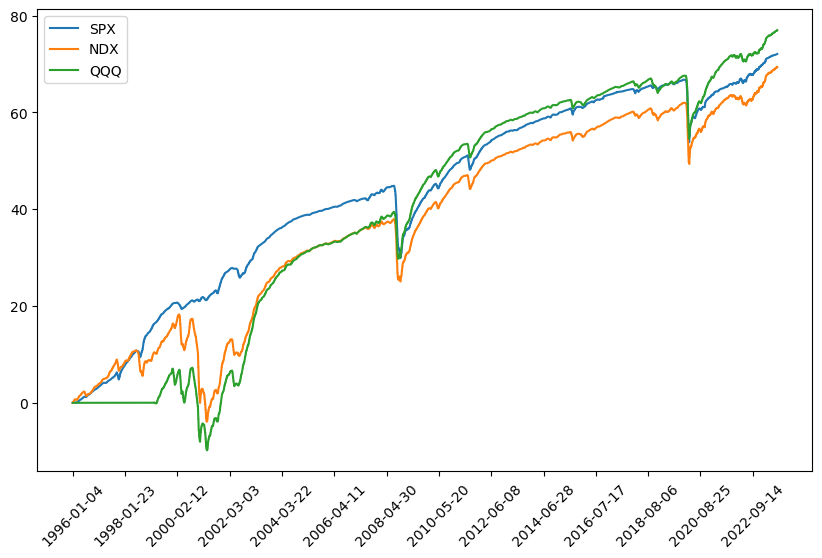

In [97]:
# Convert the 'date' column to datetime
summary_dly_df["date"] = pd.to_datetime(summary_dly_df["date"])

# Create a global date range that covers all dates in your DataFrame.
all_dates = pd.date_range(start=summary_dly_df["date"].min(), 
                          end=summary_dly_df["date"].max(), freq="D")

import matplotlib.pyplot as plt
import numpy as np

ticker_list = ["SPX", "AMZN", "NDX", "TSLA"]
ticker_list = ["SPX", "NDX", "QQQ"]

plt.figure(figsize=(10, 6))

for ticker in ticker_list:
    # Filter and set the date as index
    df_ticker = summary_dly_df[summary_dly_df["ticker"] == ticker].copy()
    df_ticker.set_index("date", inplace=True)
    
    # Calculate the daily returns
    returns = df_ticker["SW"] - df_ticker["RV"]
    
    # Reindex the returns to the complete date range, filling missing days with 0
    returns = returns.reindex(all_dates, fill_value=0)
    
    # Compute the cumulative return
    cum_ret = returns.cumsum()
    
    # Plot cumulative returns for this ticker
    plt.plot(all_dates, cum_ret, label=ticker)

# Set x-ticks to display one label every 1000 days, rotated for better readability
plt.xticks(all_dates[::750], rotation=45)
plt.legend()
plt.show()

## Table 4 (CAPM alpha regression)

## Table 5 (Fama-French alpha regression)

## Table 6 (Constant SW premium test)

## Table 10 (2 subsamples SW/RV ect.)